**Submission deadline:**
* **Regular problems: last lab session before or on Monday, 13.01.2020**
* **Bonus problems: Last lab during semester**

**Points: 5 + 9 bonus points**

Please note: some of the assignments are tedious or boring if you are already a NumPy ninja. The bonus problems were designed to give you a more satisfying alternative.

## Heads Up!

This assignment comes with starter code, but you are not forced to use it, as long as you execute all analysis demanded in the problems.

## A note about plots!

Plots are a way of communication. Just lke text, they can be paraphrased. You do not have to exactly reproducy my plots, but you must try to make suer yourp plots tell a similar story:
- label axis
- add titles
- choose plot type properly
- choose a color scale, limits, ticks

so that you can describe what is happening!

## Bugs?!

Please submit Github PRs or email us about any problems with the notebook - we will try to correct them quickly. 

In [0]:
# Standard IPython notebook imports
%matplotlib inline

import os

from io import StringIO
import itertools
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

import scipy.stats as sstats
import scipy.optimize as sopt

import seaborn as sns

import sklearn.datasets
import sklearn.ensemble
import sklearn.svm
import sklearn.tree
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import cvxopt
from sklearn.metrics.pairwise import rbf_kernel
from scipy.linalg import solve_triangular

# In this way we can import functions straight from github
with httpimport.github_repo('janchorowski', 'nn_assignments', 
                            module='common', branch='nn18'):
     from common.plotting import plot_mat

sns.set_style('whitegrid')


# SVM Theory
A linear SVM assigns points $x^{(i)}\in\mathbb{R}^n$ to one of two
classes,  $y^{(i)}\in\{-1,1\}$ using the decision rule:

\begin{equation}
y = \text{signum}(w^T x + b).
\end{equation}

SVM training consists of finding weights $w\in\mathbb{R}^n$
and bias $b\in\mathbb{R}$ that maximize the separation margin. This
corresponds to solving the following quadratic optimization problem:

\begin{equation}
\begin{split}
  \min_{w,b,\xi}  &\frac{1}{2}w^Tw  + C\sum_{i=1}^m \xi_i  \\
  \text{s.t. } & y^{(i)}(w^T x^{(i)} + b) \geq 1- \xi_i\;\; \forall_i \\
  & \xi_i \geq 0 \;\; \forall_i.
\end{split}
\end{equation}

# Problem 1 [2p]

Load the iris dataset. 

1. [1p] Using the `sklearn.svm.SVC` library train a linear SVM that
separates the Virginica from the Versicolor class using the
petal length and petal width features. Plot the obtained decision boundary and
the support vectors (their locations and weights - coefficients $\alpha$).

2. [.5p] Now train a nonlinear SVM using the Gaussian kernel. Tune the parameetrs `C` and `gamma` (for the kernel) to reach maximum training accurracy. Plot the decision boundary and supprt vectors.

3. [.5p] Answer the following questions:
    - When the SVM is forced to maximally accurate on the train set, roughly how many support vectors do we get ?
    - what is the relationship between the regularization constant `C` and the support vector weights `alpha`?
  
  

Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

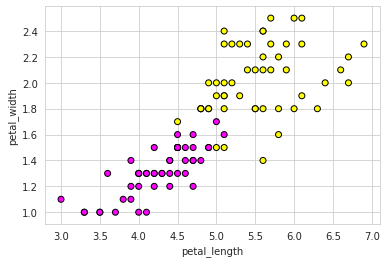

In [2]:
# load iris, extract petal_length and petal_width of versicolors and virginicas

iris = sklearn.datasets.load_iris()
print('Features: ', iris.feature_names)
print('Targets: ', iris.target_names)
petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisX = np.array(iris.data.T)
IrisX = IrisX[:, iris.target!=0]

IrisX2F = np.vstack([petal_length, petal_width])
IrisX2F = IrisX2F[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)

plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')
plt.xlabel('petal_length')
plt.ylabel('petal_width')

In [3]:
#
# Fit a linear SVM using libsvm
#

svm_model = sklearn.svm.SVC(gamma='auto', kernel='linear', C=60)
svm_model.fit(IrisX2F.T, IrisY.T)

print("libsvm error rate: %f" % (svm_model.predict(IrisX2F.T)!=IrisY).mean())

libsvm error rate: 0.060000


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 1.0, 'Decision boundary found by libsvm')

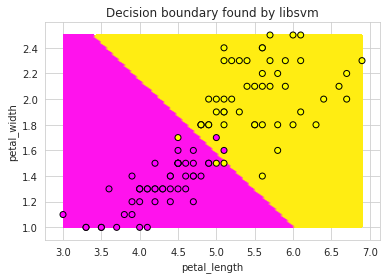

In [4]:
#
# Plot the decision boundary
#

petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = svm_model.predict(IrisXGrid.T)

plt.contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')

plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title('Decision boundary found by libsvm')

[[-60.         -43.22351664 -60.         -60.         -60.
  -60.          60.          60.          60.           7.52074002
   60.          35.70277661  60.        ]]
[[-32.63504089 -15.94952765 -31.08962778 -32.63504089 -30.99865765
  -31.27135223  87.18301887  87.72862381  88.91037222  36.79477694
   88.09228851  64.97702933  88.91037222]]


Text(0.5, 1.0, 'Decision boundary found by libsvm')

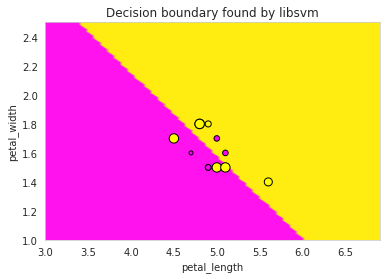

In [5]:
#
# Plot the decision boundary and the support vectors.
#
# You can extract the indices of support vectors and their weights from fields of the 
# svm object. Display the location of support vectors and their weights (by changing the 
# size in the scatterplot)
#
# TODO
#

support_vector_indices = svm_model.support_
support_vector_coefficients = svm_model.dual_coef_
preds = np.dot(svm_model.coef_, svm_model.support_vectors_.T) + support_vector_coefficients[0]

print(support_vector_coefficients)
print(preds)
sizes = np.abs(preds)

plt.contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
plt.scatter(IrisX2F[0,support_vector_indices], IrisX2F[1,support_vector_indices],
            c=IrisY.ravel()[support_vector_indices],
            s=sizes,
            cmap='spring',
            edgecolors='k')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title('Decision boundary found by libsvm')

libsvm error rate: 0.010000


Text(0.5, 1.0, 'Decision boundary found by libsvm')

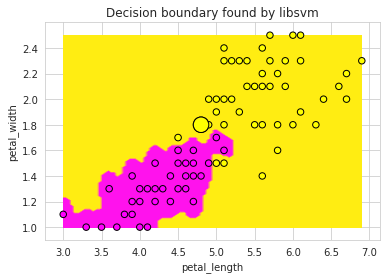

In [6]:
#
# Fit a nonlinear SVM with a Gaussian kernel using libsvm.
# Optimize the SVM to make 
#

svm_gauss_model = sklearn.svm.SVC(gamma=90, kernel='rbf', C=100)
svm_gauss_model.fit(IrisX2F.T, IrisY.T.ravel())

print("libsvm error rate: %f" % (svm_gauss_model.predict(IrisX2F.T)!=IrisY).mean())

predictions_Grid = svm_gauss_model.predict(IrisXGrid.T)

support_vector_indices = svm_gauss_model.support_
support_vector_coefficients = svm_gauss_model.dual_coef_

# TODO: plot the decision boundary with support vectors
plt.contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
plt.scatter(IrisX2F[0,support_vector_indices], IrisX2F[1,support_vector_indices],
            c=IrisY.ravel()[support_vector_indices],
            s=abs(support_vector_coefficients) * 2 + 40,
            cmap='spring',
            edgecolors='k')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title('Decision boundary found by libsvm')

# Problem 2 [1p]

Reimplement the linear SVM using the use `cvxopt.solvers.qp`
Quadratic Programming (QP) solver. You will need to define the matrices
that define the problem. Compare the obtained solutions. Extract the
support vectors from the LIBSVM solution and plot the support vectors.

The `cvxopt.solvers.qp` solves the following optimization problem: 

\begin{align}
\text{minimize over } x \text{: }& \frac{1}{2} x^T P x + q^T x \\
\text{subject to: } & Gx \leq h \\
& Ax = b
\end{align}

<br>
SVM problem to compare:
<br>
\begin{equation}
\begin{split}
  \min_{w,b,\xi}  &\frac{1}{2}w^Tw  + C\sum_{i=1}^m \xi_i  \\
  \text{s.t. } & y^{(i)}(w^T x^{(i)} + b) \geq 1- \xi_i\;\; \forall_i \\
  & \xi_i \geq 0 \;\; \forall_i.
\end{split}
\end{equation}

<br> 

To solve the SVM problem you need to encode the weights $W$, biases $b$, and slack variables $\xi$ as elements of the vector $x$, then properly fill the matrices and vectors $P$, $q$, $G$, $h$. We can ignore setting the $A$ and $b$ parametrs, since there are no linear constraints.

In [7]:
#
# Now solve the SVM using the QP solver
#


y = IrisY.T.ravel() * 2 - 1
n, m = IrisX2F.shape
C= 10.0

P = np.zeros((n+1+m, n+1+m)) #w, bias, xi
q = np.zeros((n+1+m,1)) 
G = np.zeros((2*m, n+1+m)) # we have two constrains for each data point: 
                           # that the margin is equal to 1-xi
                           # and that xi is nonnegative
h = np.zeros((2*m,1))
#
# TODO: fill in P, q, G, h
#

for i in range(m):
    h[i] = -1
    q[n+1+i] = C
    G[i][n] = -y[i]
    G[i][n+1+i] = -1
    G[m+i][n+1+i] = -1
    for j in range(n):
        G[i][j] = -y[i] * IrisX2F[j][i]

for i in range(n):
    P[i][i] = 1

#
# Now run the solver
#
ret  = cvxopt.solvers.qp(cvxopt.matrix(P), cvxopt.matrix(q), 
                         cvxopt.matrix(G), cvxopt.matrix(h))

ret = np.array(ret['x'])
support_vextors = IrisX2F
#
# extract the weights and biases
#
W = ret[:n].reshape(-1,1)
b = ret[n]

#
# Extract the weight and bias from libsvm for comparison
#

svm_model = sklearn.svm.SVC(gamma='auto', kernel='linear', C=C)
svm_model.fit(IrisX2F.T, y)

Wlibsvm = svm_model.coef_
blibsvm = svm_model.intercept_

print('W', W.T, 'Wlibsvm', Wlibsvm)
print('b', b, 'blibsvm', blibsvm)

     pcost       dcost       gap    pres   dres
 0: -8.2045e+03  4.6654e+03  2e+04  2e+01  3e+00
 1:  5.3426e+01 -5.8951e+02  3e+03  2e+00  4e-01
 2:  1.7058e+02 -1.9137e+01  4e+02  3e-01  5e-02
 3:  1.4063e+02  7.5166e+01  1e+02  7e-02  1e-02
 4:  1.3820e+02  9.8722e+01  6e+01  3e-02  5e-03
 5:  1.4016e+02  1.1207e+02  3e+01  4e-03  8e-04
 6:  1.3507e+02  1.1797e+02  2e+01  1e-03  2e-04
 7:  1.2551e+02  1.2356e+02  2e+00  2e-04  3e-05
 8:  1.2445e+02  1.2440e+02  5e-02  4e-06  6e-07
 9:  1.2442e+02  1.2442e+02  1e-03  9e-08  2e-08
10:  1.2442e+02  1.2442e+02  2e-05  1e-09  1e-10
Optimal solution found.
W [[2.75844069 4.827271  ]] Wlibsvm [[2.75873306 4.82861713]]
b [-21.2054472] blibsvm [-21.20914737]


# Problem 3 [2p]

Repeat 100 bootstrap experiments to establish the effect of constant $C$ on SVM.

For each experiment do the following:

1. Sample (with replacement) a bootstrap dataset equal in size to the
    training dataset. This will be this experiment's training dataset.
2. Prepare the experiment's testing dataset by using samples not
    inluded in the bootstrap dataset.
3. For all $C$ from the set $\{10^{-4}, 10^{-3.5}, 10^{-3.}, \ldots, 10^{6}\}$
    fit a nonlinear SVM (Gaussian kernel, called \texttt{rbf} in
    LIBSVM using the default $\gamma$) and record the training and
    testing errors.

Analyze a box plot of errors as a function of $C$. Can you see its
influence on the training and testing error, as well as on the
testing error variability? 

**Indicate regions of overfitting and underfitting.**



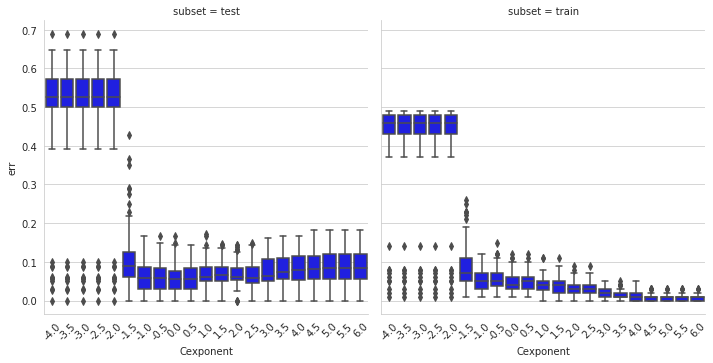

In [8]:
res = []
iters = 100
for rep in range(iters):
    bootstrap_sel = resample(np.arange(len(IrisX.T)), n_samples = len(IrisX.T))
    test_sel = np.array([i for i in np.arange(len(IrisX.T)) if not i in bootstrap_sel])

    bootstrap_IrisX = IrisX2F[:,bootstrap_sel].T
    bootstrap_IrisY = IrisY[:,bootstrap_sel].T
    
    test_IrisX = IrisX2F[:,test_sel].T
    test_IrisY = IrisY[:,test_sel].T
    
    #
    # TODO: Loop over a list of exponents.
    #
    for Cexponent in np.arange(-4, 6.5, 0.5):
        C = 10.0**Cexponent
        svm_model = sklearn.svm.SVC(gamma='auto', kernel='rbf', C=C)
        svm_model.fit(bootstrap_IrisX, bootstrap_IrisY.ravel())
        train_acc = (svm_model.predict(bootstrap_IrisX) == bootstrap_IrisY.ravel()).mean()
        test_acc = (svm_model.predict(test_IrisX) == test_IrisY.ravel()).mean()

        # VISUALIZATION
        # predictions_Grid = svm_model.predict(IrisXGrid.T)
        # plt.contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')
        # plt.scatter(bootstrap_IrisX[:, 0], bootstrap_IrisX[:, 1],
        #     c=svm_model.predict(bootstrap_IrisX),
        #     cmap='spring',
        #     edgecolors='black')
        # plt.show()
        # print(train_acc, test_acc)
  
        res.append(dict(Cexponent=Cexponent, err=1-test_acc, subset='test'))
        res.append(dict(Cexponent=Cexponent, err=1-train_acc, subset='train'))

res = pd.DataFrame(res)
chart = sns.catplot(kind='box', x='Cexponent', y='err', col='subset', 
            color='blue', data=res)
chart.set_xticklabels(rotation=45)

# Problem 4 [3p bonus]

Implement a nonlinear SVM by solving the dual problem using the Quadratic Programming solver. Compare results with LIBSVM.

Please see [page 20 if CS229 lecture notes](http://cs229.stanford.edu/notes/cs229-notes3.pdf) for problem formulation.

Soft SVM, dual problem:
\begin{aligned}
    \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
     s.t.  - \alpha_i \leq 0 
    \\
      \alpha_i \leq C
     \\
     \ y^T \alpha = 0  
     \\ 
     \ H = y^TKy  
     \\
     \ K_{i,j} = K(x_i,x_j)
\end{aligned}


Solver form:
\begin{align}
\text{minimize over } x \text{: }& \frac{1}{2} x^T P x + q^T x \\
\text{subject to: } & Gx \leq h \\
& Ax = b
\end{align}


In [0]:
def get_bias(X,y,alphas,S,gamma=1):
    support_vextors = X[S]
    sv_target = y[S]
    B = []
    for i,sv in enumerate(support_vextors):
        b = sv_target[i] - np.sum(rbf_kernel(support_vextors,sv.reshape(1,-1),gamma=gamma).ravel() * sv_target.ravel() * alphas[S].ravel())
        # b == np.array of length 1
        B.append(b[0])
    return sstats.mode(np.array(B))[0][0]


def predict(X,y,sample,alphas,b,S,gamma=1):
    SX = X[S]
    Sy = y[S]
    v = np.sum(rbf_kernel(SX,sample.reshape(1,-1),gamma=gamma).ravel() * Sy.ravel() * alphas[S].ravel()) + b
    return np.sign(v)


def predict_all(Y,gamma=90):
  preds = []
  for sample in Y:
      preds.append(predict(X,y,sample,alphas,b,S,gamma=gamma))
  return np.array(preds)

In [10]:
C = 1
gamma = 90
th = 1e-5

X = IrisX2F.T
y = (IrisY * 2 - 1).reshape(-1,1)
m,n = X.shape
K = rbf_kernel(X,X,gamma=gamma) # rbf kernel from sklearn

P = cvxopt.matrix(np.outer(y,y) * K)
q = cvxopt.matrix(-np.ones((m, 1)))
G = cvxopt.matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * C)))
A = cvxopt.matrix(y.reshape(1, -1))
b = cvxopt.matrix(np.zeros(1))

#Run solver
sol = cvxopt.solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0: -2.7886e+01 -2.0457e+02  7e+02  2e+00  5e-16
 1: -2.6152e+01 -1.2082e+02  9e+01  8e-15  4e-16
 2: -2.8097e+01 -3.9348e+01  1e+01  8e-15  2e-16
 3: -2.9282e+01 -3.0253e+01  1e+00  3e-15  2e-16
 4: -2.9435e+01 -2.9508e+01  7e-02  4e-15  2e-16
 5: -2.9451e+01 -2.9454e+01  3e-03  2e-15  1e-16
 6: -2.9452e+01 -2.9452e+01  2e-04  7e-15  2e-16
 7: -2.9452e+01 -2.9452e+01  1e-05  3e-15  1e-16
Optimal solution found.


In [0]:
# take alphas > 0
S = (alphas > th).reshape(-1, )

In [12]:
b = get_bias(X,y,alphas,S,gamma)
b

0.2171403129519649

In [0]:
preds = []
for i in range(100):
    s = X[i]
    preds.append(predict(X,y,s,alphas,b,S,gamma=gamma))
preds = np.array(preds)

In [14]:
print(f'Accuracy: {np.mean(preds == y.ravel()) * 100}%')

Accuracy: 99.0%


Text(0.5, 1.0, 'Decision boundary found by SVM, kernel = rbf, gamma = 90, c = 1')

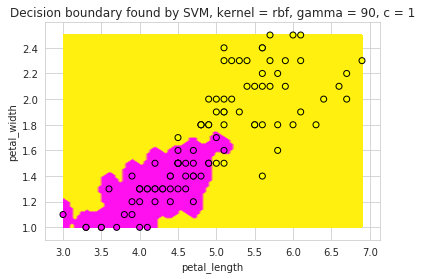

In [15]:
petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid = predict_all(IrisXGrid.T,gamma=gamma)

plt.contourf(petal_lengths, petal_widths, predictions_Grid.reshape(petal_lengths.shape), cmap='spring')

plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')

plt.xlabel('petal_length')
plt.ylabel('petal_width')
plt.title(f'Decision boundary found by SVM, kernel = rbf, gamma = {gamma}, c = {C}')

# Problem 5 [2p bonus]
Compare two ways to implement a multi-class
SVM: by training ``1-vs-1`` classifier for each class combination,
and by training a ``1-vs-rest`` classifier for each clas. See
http://www.csie.ntu.edu.tw/\~cjlin/papers/multisvm.pdf for
details.


Features:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Targets:  ['setosa' 'versicolor' 'virginica']


Text(0, 0.5, 'petal_width')

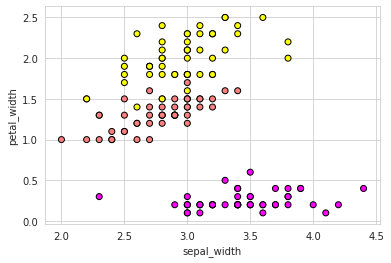

In [16]:
# load iris, extract septal_width and petal_width of all classes

iris = sklearn.datasets.load_iris()
print('Features: ', iris.feature_names)
print('Targets: ', iris.target_names)
petal_length = iris.data[:,iris.feature_names.index('sepal width (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisX = np.array(iris.data.T)

IrisX2F = np.vstack([petal_length, petal_width])


IrisY = iris.target.reshape(1,-1).astype(np.float64)

plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')
plt.xlabel('sepal_width')
plt.ylabel('petal_width')

In [0]:
def get_models(X,y,C=10,gamma=1):
    classes = np.unique(y)
    models = []
    for c in classes:
        Y = ((y == c) * 2 - 1).ravel()
        svm_model = sklearn.svm.SVC(kernel='rbf',C=C,gamma=gamma)
        svm_model.fit(X.T,Y)
        models.append(svm_model)
    return models

def predict_one_vs_rest(models,X,classes):
    l = []
    for model in models:
        l.append(list(model.decision_function(X.T)))
    l = np.array(l)
    preds = np.argmax(l, axis=0)
    return classes[preds]

In [0]:
C=1
gamma=10

models = get_models(IrisX2F,IrisY,C,gamma)
classes = np.unique(IrisY)

## One vs rest
Also known as one-vs-all, this strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. <br>
For m classes, we will have m probability estimates of positive class for one test sample. Compare them and whichever probability is maximum of m probabilities, it belongs to that particular class.
I.e. to determine the final class we take argmax of all predictions. <br>
 This is the most commonly used strategy for multiclass classification and is a fair default choice.

Text(0.5, 1.0, 'One vs rest, kernel = rbf, gamma = 10, c = 1')

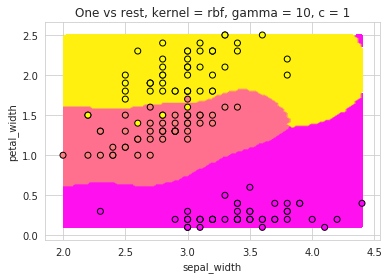

In [19]:
sepal_width, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([sepal_width.ravel(), petal_widths.ravel()])
predictions_Grid = predict_one_vs_rest(models, IrisXGrid, classes)

plt.contourf(sepal_width, petal_widths, predictions_Grid.reshape(sepal_width.shape), cmap='spring')
plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')

plt.xlabel('sepal_width')
plt.ylabel('petal_width')
plt.title(f'One vs rest, kernel = rbf, gamma = {gamma}, c = {C}')

## One vs one:

Two pairs of classes are selected at a time and a binary classifier trained for them. This is done for every possible pair of classes thus there are n(n-1)/2 of them where n is the total number of classes. During the classification phases, all the binary classifiers are tested. For each of them, a “win” for one class is a vote for that class. The class with the most votes wins.

In [0]:
def get_models_ovo(X,y,C=10,gamma=1):
    classes = np.unique(y)
    models = []
    for i in range(len(classes)):
        for j in range(i+1,len(classes)):
            c1,c2 = classes[i],classes[j]
            idx = np.logical_or(IrisY == c1, IrisY == c2).ravel()
            X_ = X.T[idx]
            Y_ = t = (IrisY == c1) * 1 + (IrisY == c2) * -1
            Y_ = Y_[Y_!=0]
            svm_model = sklearn.svm.SVC(kernel='rbf',C=C,gamma=gamma)
            svm_model.fit(X_,Y_)
            models.append((svm_model,c1,c2))
    return models


def predict_one_vs_one(models,X): 
  l = []
  for model,c1,c2 in models:
      preds = model.decision_function(X.T)
      preds = [c1 if np.sign(p) == 1.0 else c2 for p in preds]
      l.append(preds)
  l = np.array(l)
  preds = sstats.mode(l,axis=0)
  return preds[0]

In [0]:
models = get_models_ovo(IrisX2F,IrisY,C,gamma)

Text(0.5, 1.0, 'One vs one, kernel = rbf, gamma = 10, c = 1')

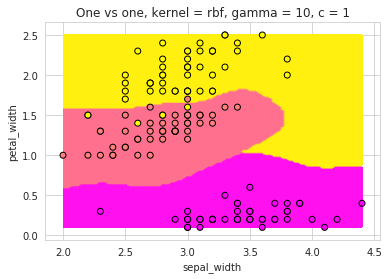

In [22]:
sepal_width, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([sepal_width.ravel(), petal_widths.ravel()])

predictions_Grid2 = predict_one_vs_one(models,IrisXGrid)

plt.contourf(sepal_width, petal_widths, predictions_Grid2.reshape(sepal_width.shape), cmap='spring')

plt.scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),
            cmap='spring', edgecolors='k')

plt.xlabel('sepal_width')
plt.ylabel('petal_width')
plt.title(f'One vs one, kernel = rbf, gamma = {gamma}, c = {C}')

## Comparison between One vs All and One vs One

Text(0, 0.5, 'petal_width')

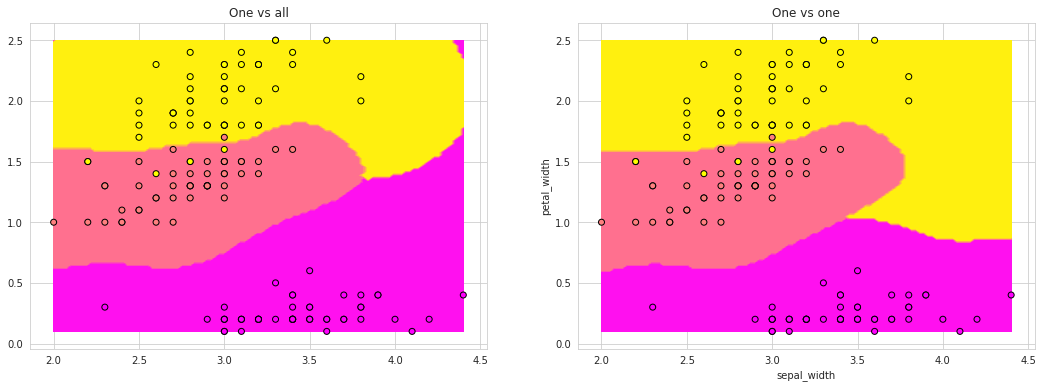

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].contourf(sepal_width, petal_widths, predictions_Grid.reshape(sepal_width.shape), cmap='spring')
ax[0].scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),cmap='spring', edgecolors='k')
ax[0].set_title('One vs all')
ax[1].contourf(sepal_width, petal_widths, predictions_Grid2.reshape(sepal_width.shape), cmap='spring')
ax[1].scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),cmap='spring', edgecolors='k')
ax[1].set_title('One vs one')
plt.xlabel('sepal_width')
plt.ylabel('petal_width')

# Problem 6 [4p bonus]

Implement a Kernelized linear regression. Train it on Iris using a Gaussian kernel. Compare to the non-linear SVM.

We know that in linear regression optimal solution can be described as $\theta_0 = (X^T X + \lambda I)^{-1} X^T Y $. 

We know that this problem has dual formulation, and we can say that: $ \theta_0 = X^T (X X^T + \lambda I)^{-1} Y $

Now we can define that $ \alpha = (K + \lambda I)^{-1} Y$, where $K_{i,j} = <x^{(i)},x^{(j)}>$, and when we have to predict new point $x$ we know that $
f(x) = \sum_{i=0}^{n} \alpha_i <x,x^{(i)}> $.

Now insted of using dot prodact we can use kernel trick.

So given new sample $x$ we can say that:

$f(x) = \sum_{i=0}^{n} \alpha_i K(x,x^{(i)})
\\ \alpha = (K + \lambda I)^{-1} Y
\\ K_{i,j} = K(x^{(i)},x^{(j)}) $


In [0]:
def qr_inv(a):
    q,r = np.linalg.qr(a, mode='complete')
    N = r.shape[0]
    inv_ = np.dot(solve_triangular(r,np.eye(N)),q.T)
    return inv_

  
def classify_LS_SVM(X,sample,alphas,gamma=1):
    return np.sign(np.sum(rbf_kernel(X,sample.reshape(1,-1),gamma=gamma).ravel() * alphas))


def predict_LS_SVM(X,Y,alphas,gamma=1):
    preds = []
    for sample in Y:
        preds.append(classify_LS_SVM(X,sample,alphas,gamma=gamma))
    return np.array(preds)

In [0]:
gamma = 90
lambda_ = 1.0

petal_length = iris.data[:,iris.feature_names.index('petal length (cm)')]
petal_width = iris.data[:, iris.feature_names.index('petal width (cm)')]

IrisX = np.array(iris.data.T)
IrisX = IrisX[:, iris.target!=0]

IrisX2F = np.vstack([petal_length, petal_width])
IrisX2F = IrisX2F[:, iris.target!=0]

# Set versicolor=0 and virginia=1
IrisY = (iris.target[iris.target!=0]-1).reshape(1,-1).astype(np.float64)
m
X = IrisX2F.T
y = (IrisY * 2 - 1).reshape(-1,1)
Y = y.ravel()

n,m = X.shape
K = rbf_kernel(X,X,gamma=gamma)
alphas_ls = qr_inv(K + lambda_ * np.eye(n)).dot(Y)

In [26]:
np.mean(predict_LS_SVM(X,IrisX2F.T,alphas_ls) == Y)

0.96

Text(0, 0.5, 'petal_width')

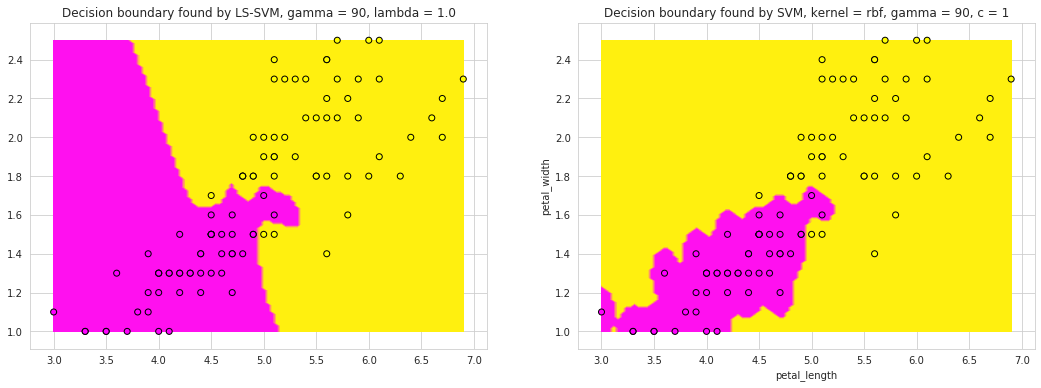

In [27]:
petal_lengths, petal_widths = np.meshgrid(np.linspace(IrisX2F[0,:].min(), IrisX2F[0,:].max(), 100),
                                          np.linspace(IrisX2F[1,:].min(), IrisX2F[1,:].max(), 100))

IrisXGrid = np.vstack([petal_lengths.ravel(), petal_widths.ravel()])
predictions_Grid_LS_SVM = predict_LS_SVM(X,IrisXGrid.T,alphas_ls,gamma=gamma)
predictions_Grid_NL_SVM = predict_all(IrisXGrid.T,gamma=90)

fig, ax = plt.subplots(1, 2, figsize=(18,6))

ax[0].contourf(petal_lengths, petal_widths, predictions_Grid_LS_SVM.reshape(petal_lengths.shape), cmap='spring')
ax[0].scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),cmap='spring', edgecolors='k')
ax[0].set_title(f'Decision boundary found by LS-SVM, gamma = {gamma}, lambda = {lambda_}')


ax[1].contourf(petal_lengths, petal_widths, predictions_Grid_NL_SVM.reshape(petal_lengths.shape), cmap='spring')
ax[1].scatter(IrisX2F[0,:], IrisX2F[1,:], c=IrisY.ravel(),cmap='spring', edgecolors='k')
ax[1].set_title(f'Decision boundary found by SVM, kernel = rbf, gamma = {gamma}, c = {C}')

plt.xlabel('petal_length')
plt.ylabel('petal_width')